In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [52]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.elevation_intermediate = []
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.customer_points_intermediate = {}
        self.depot = None
        self.d_ij_indices = {} 
        self.n_intermediate = 0
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.output_matrix_extended = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        self.servicetime = 5 # minutes
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(9)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            self.tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            self.tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return self.tw_a, self.tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            self.tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            self.tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            # np.random.shuffle(tw_a); np.random.shuffle(tw_b)
            return self.tw_a, self.tw_b
        if tp == 'single':
            self.tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
    
    def payload(self, min_p=5, max_p=30):
        self.load = np.append(np.zeros(1), np.random.randint(min_p, max_p, self.n_customers))
    
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(9);
        x_c = random.sample([i for i in range(1, self.n_x+1)], n_customers)
        y_c = random.sample([i for i in range(1, self.n_y+1)], n_customers)
        customer_points = [elem for elem in zip(x_c, y_c)]
        self.customer_points = {k:self.grid[k] for k in zip(x_c, y_c)}
        # customer_points = random.sample(list(self.grid.items()), n_customers)
        # self.customer_points = {k:v for k, v in customer_points}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])
        
    def plot_customer_number(self):
        k = list(self.customer_points.keys())
        a=np.empty((self.n_x+1,self.n_y+1))
        for x in range(self.n_x+1):
            for y in range(self.n_y+1):
                a[x,y]=self.elevation[(x,y)]
        #self.plot_grid()
        plt.imshow(a,alpha=0.3, cmap='gnuplot2_r', interpolation='bicubic',origin='lower') 
        count=0 
        for i in range(self.n_customers):
            count+=1
            plt.text(k[i][0], k[i][1], f"{count}", fontsize=12)
        
    def customers_paths(self, depot):
        ## # depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())  # we work with grid indices instead of coordinates
        nodes.insert(0, depot)
        print(nodes)
        
        # we insert an intermediate point only if the two points are not on the same horizontal or vertical line 
        # a variation could be to use a point internal to the horizontal/vertical edge if the the latter is longer than 1 grid point
        self.n_intermediate = 0    
        for i in range(self.n_customers+1):
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                if (dx_index != 0 and dy_index != 0):
                    self.n_intermediate += 1
        self.n_intermediate //= 2
        print('n_intermediate', self.n_intermediate)  
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((self.n_customers+1+self.n_intermediate, self.n_customers+1+self.n_intermediate))
        
        self.customer_points_intermediate = self.customer_points.copy()
        int_node = 0
        for i in range(self.n_customers+1):
            print('node:', i, nodes[i])
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                node_int = (nodes[i][0] - dx_index, nodes[i][1])
                self.d_ij_indices[(i,j)] = (nodes[i], node_int, nodes[j])
                # self.d_ij_indices[(i,j)] = ((nodes[i][0], nodes[i][1]), (nodes[i][0]-dx_index, nodes[i][1]), (nodes[j][0], nodes[j][1]))
                print(self.d_ij_indices[(i,j)])
                
                dx = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])
                dy = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                self.d_ij[i,j] = dx + dy
                self.d_ij_extended[i,j] = dx + dy 
                
                if (dx_index != 0 and dy_index != 0) and (self.grid[node_int][1] <= self.grid[nodes[j]][1]):
                    self.customer_points_intermediate[node_int] = self.grid[node_int]
                    int_node += 1
                    self.d_ij_extended[i,self.n_customers+int_node] = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])   
                    self.d_ij_extended[self.n_customers+int_node,i] = self.d_ij_extended[i,self.n_customers+int_node]#abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[j,self.n_customers+int_node] = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[self.n_customers+int_node,j] = self.d_ij_extended[j,self.n_customers+int_node]
                    self.elevation_intermediate.append(self.elevation[node_int])
                    
        print('d_ij_indices\n', self.d_ij_indices)
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        # elevation_intermediate = np.zeros(self.n_customers+self.n_intermediate)
        
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        # for i, k in enumerate(self.customer_points_intermediate.keys()):
        #     elevation_intermediate[i] = self.elevation[k]
         
        elevation = np.append(self.elevation[self.depot], elevation)
        elevation_intermediate = np.append(elevation, self.elevation_intermediate)
        
        service_time = np.append(np.zeros(1), np.array([self.servicetime for _ in range(self.n_customers)]) )
        service_time_intermediate = np.append(service_time, np.nan*np.ones(self.n_intermediate))
        
        x = np.append(self.grid[self.depot][0], np.array([v[0] for v in self.customer_points.values()]) )
        y = np.append(self.grid[self.depot][1], np.array([v[1] for v in self.customer_points.values()]) )
        x_intermediate = np.append(x, np.zeros(self.n_intermediate))
        y_intermediate = np.append(y, np.zeros(self.n_intermediate))
        
        index = np.linspace(0,self.n_customers,self.n_customers+1)
        index_intermediate = np.linspace(0,self.n_customers+self.n_intermediate,self.n_customers+self.n_intermediate+1)
        
        self.output_matrix = np.c_[index, x, y, elevation, self.load, self.tw_a, self.tw_b, service_time, self.d_ij/1000]
        
        load_intermediate = np.append(self.load.copy(), -np.ones(self.n_intermediate))
        tw_a_intermediate = np.append(self.tw_a.copy(), np.zeros(self.n_intermediate))
        tw_b_intermediate = np.append(self.tw_b.copy(), np.zeros(self.n_intermediate))
        service_time_intermediate = np.append(service_time.copy(), np.zeros(self.n_intermediate))
        self.output_matrix_extended = np.c_[index_intermediate, x_intermediate, y_intermediate, elevation_intermediate, load_intermediate, tw_a_intermediate, 
                                            tw_b_intermediate, service_time_intermediate, self.d_ij_extended/1000]
                                            
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1):
            header += ','+str(i)
           
        np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1+self.n_intermediate):
            header += ','+str(i)
        
        np.savetxt('generated_grid_1_extended.csv', self.output_matrix_extended, delimiter=',', header=header, comments='')
                                            
        return self.output_matrix

In [53]:
G = grid(10, 10)
print(G.grid[(1,3)])
print(G.grid[(5,3)])

(102.0, 302.0)
(513.0, 302.0)


In [54]:
np.linspace(0,21,22)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21.])

In [55]:
np.append(np.zeros(1), np.random.randint(5, 10, 5))

array([0., 6., 7., 6., 7., 8.])

In [56]:
a,b = G.time_windows(tp='single', min_t= 50, max_t=400)


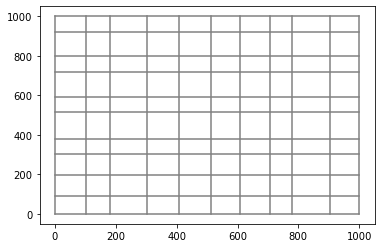

In [60]:
G.plot_grid()

In [61]:
print(np.round(G.x_points, 2))
print(np.round(G.y_points, 2))
print(G.n_x)

[   0.  102.  181.  302.  407.  513.  609.  708.  780.  904. 1000.]
[   0.   92.  198.  302.  381.  515.  591.  717.  799.  918. 1000.]
10


In [62]:
print(G.elevation[(0,0)])
print(G.elevation[(3,5)])

22.950551869092376
10.627392858525313


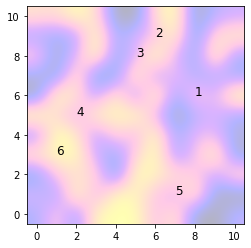

In [63]:
G.customers(6)
# for i in range(2,5): print(i)
G.plot_customer_number()

In [64]:
for v in G.customer_points.items():
    print(v)

((8, 6), (780.0, 591.0))
((6, 9), (609.0, 918.0))
((5, 8), (513.0, 799.0))
((2, 5), (181.0, 515.0))
((7, 1), (708.0, 92.0))
((1, 3), (102.0, 302.0))


In [55]:
for v in G.customer_points_intermediate.items():
    print(v)

In [56]:
for v in G.customer_points_intermediate.keys():
    print(v)

In [57]:
for v in G.customer_points_intermediate.keys():
    print(G.elevation[v])

In [58]:
# G.customer_points
print(G.n_intermediate)
print(len(G.customer_points_intermediate))

0
0


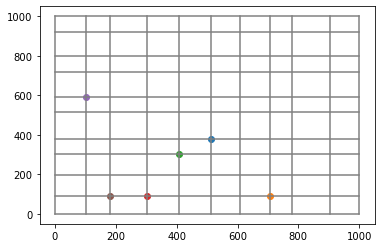

In [59]:
G.plot_customer_points()

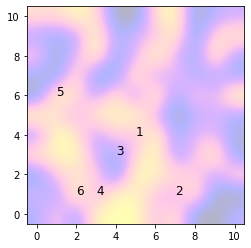

In [60]:
G.plot_customer_number()

In [61]:
# print(G.elevation.keys())
# print(G.d_ij_extended.keys())
print(np.shape(G.d_ij_extended))

()


In [62]:
G.customers_paths((0,0))

[(0, 0), (5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1)]
n_intermediate 18
node: 0 (0, 0)
((0, 0), (0, 0), (0, 0))
((0, 0), (5, 0), (5, 4))
((0, 0), (7, 0), (7, 1))
((0, 0), (4, 0), (4, 3))
((0, 0), (3, 0), (3, 1))
((0, 0), (1, 0), (1, 6))
((0, 0), (2, 0), (2, 1))
node: 1 (5, 4)
((5, 4), (0, 4), (0, 0))
((5, 4), (5, 4), (5, 4))
((5, 4), (7, 4), (7, 1))
((5, 4), (4, 4), (4, 3))
((5, 4), (3, 4), (3, 1))
((5, 4), (1, 4), (1, 6))
((5, 4), (2, 4), (2, 1))
node: 2 (7, 1)
((7, 1), (0, 1), (0, 0))
((7, 1), (5, 1), (5, 4))
((7, 1), (7, 1), (7, 1))
((7, 1), (4, 1), (4, 3))
((7, 1), (3, 1), (3, 1))
((7, 1), (1, 1), (1, 6))
((7, 1), (2, 1), (2, 1))
node: 3 (4, 3)
((4, 3), (0, 3), (0, 0))
((4, 3), (5, 3), (5, 4))
((4, 3), (7, 3), (7, 1))
((4, 3), (4, 3), (4, 3))
((4, 3), (3, 3), (3, 1))
((4, 3), (1, 3), (1, 6))
((4, 3), (2, 3), (2, 1))
node: 4 (3, 1)
((3, 1), (0, 1), (0, 0))
((3, 1), (5, 1), (5, 4))
((3, 1), (7, 1), (7, 1))
((3, 1), (4, 1), (4, 3))
((3, 1), (3, 1), (3, 1))
((3, 1), (1, 1), (1, 6))


array([[   0.,  894.,  800.,  709.,  394.,  693.,  273.],
       [ 894.,    0.,  484.,  185.,  500.,  621.,  621.],
       [ 800.,  484.,    0.,  511.,  406., 1105.,  527.],
       [ 709.,  185.,  511.,    0.,  315.,  594.,  436.],
       [ 394.,  500.,  406.,  315.,    0.,  699.,  121.],
       [ 693.,  621., 1105.,  594.,  699.,    0.,  578.],
       [ 273.,  621.,  527.,  436.,  121.,  578.,    0.]])

In [63]:
G.customer_points_intermediate

{(5, 4): (513.0, 381.0),
 (7, 1): (708.0, 92.0),
 (4, 3): (407.0, 302.0),
 (3, 1): (302.0, 92.0),
 (1, 6): (102.0, 591.0),
 (2, 1): (181.0, 92.0),
 (5, 0): (513.0, 0.0),
 (7, 0): (708.0, 0.0),
 (4, 0): (407.0, 0.0),
 (3, 0): (302.0, 0.0),
 (1, 0): (102.0, 0.0),
 (2, 0): (181.0, 0.0),
 (1, 4): (102.0, 381.0),
 (5, 1): (513.0, 92.0),
 (4, 1): (407.0, 92.0),
 (1, 1): (102.0, 92.0),
 (5, 3): (513.0, 302.0),
 (1, 3): (102.0, 302.0)}

In [64]:
G.customer_points.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1)])

In [65]:
G.customer_points_intermediate.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (5, 0), (7, 0), (4, 0), (3, 0), (1, 0), (2, 0), (1, 4), (5, 1), (4, 1), (1, 1), (5, 3), (1, 3)])

In [66]:
G.d_ij_extended

array([[   0.,  894.,  800.,  709.,  394.,  693.,  273.,  513.,  708.,
         407.,  302.,  102.,  181.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 894.,    0.,  484.,  185.,  500.,  621.,  621.,  381.,    0.,
           0.,    0.,    0.,    0.,  411.,  289.,    0.,    0.,   79.,
           0.,  289.,    0.,    0.,  289.,    0.,    0.],
       [ 800.,  484.,    0.,  511.,  406., 1105.,  527.,    0.,   92.,
           0.,    0.,    0.,    0.,    0.,  195.,  301.,  606.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 709.,  185.,  511.,    0.,  315.,  594.,  436.,    0.,    0.,
         302.,    0.,    0.,    0.,    0.,    0.,  210.,    0.,  106.,
         305.,    0.,  210.,    0.,    0.,  210.,    0.],
       [ 394.,  500.,  406.,  315.,    0.,  699.,  121.,    0.,    0.,
           0.,   92.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  211.,  105.,  200.,    0.,    0.,    0.],


In [67]:
G.customer_points_intermediate.keys()

dict_keys([(5, 4), (7, 1), (4, 3), (3, 1), (1, 6), (2, 1), (5, 0), (7, 0), (4, 0), (3, 0), (1, 0), (2, 0), (1, 4), (5, 1), (4, 1), (1, 1), (5, 3), (1, 3)])

In [68]:
elevation = []
for i, k in enumerate(G.customer_points_intermediate.keys()):
            print(G.elevation[k])

4.403646954327418
28.181124087540663
21.886952164995595
3.8506881457728204
13.046661949816729
11.783433862819336
0.24435134903642797
24.34243621696351
24.127260970206237
5.323810539232055
17.45254171045143
27.892136802004448
2.2353385679873927
10.111907363258112
0.13691547008878424
23.829523378523575
4.047832333139471
17.407806369714876


In [69]:
print(G.n_intermediate)
print(G.n_customers+G.n_intermediate)
print(len(G.customer_points_intermediate))

18
24
18


In [70]:
for i, k in enumerate(G.customer_points_intermediate.keys()):
            print(G.elevation[k])

4.403646954327418
28.181124087540663
21.886952164995595
3.8506881457728204
13.046661949816729
11.783433862819336
0.24435134903642797
24.34243621696351
24.127260970206237
5.323810539232055
17.45254171045143
27.892136802004448
2.2353385679873927
10.111907363258112
0.13691547008878424
23.829523378523575
4.047832333139471
17.407806369714876


In [71]:
# G.d_ij_indices

In [72]:
# G.d_ij

In [73]:
# print(G.grid_dict()[(0,0)])
# print(G.grid_dict()[(1,7)])
# print(G.grid_dict()[(16,23)])
# print(G.grid_dict()[(19,0)])

In [74]:
# G.customer_points

In [75]:
# for k in G.customer_points.keys():
#     print(k, ' elevation: ', G.elevation[k])

In [76]:
ta, tb = G.time_windows()
print(ta)
print(tb)

[  0  89  94  77 138  73  95]
[  0 118 127  96 157  88 130]


In [77]:
G.payload()
print(len(G.elevation_intermediate))

18


In [78]:
out = G.create_csv()

In [79]:
G.elevation[(0,0)]

22.950551869092376

In [80]:
# G1 = grid(10, 10)

In [81]:
# G1.customers(20)

In [82]:
# G1.plot_customer_points()

In [83]:
# G1.customers_paths((0,0))

In [84]:
# G1.time_windows()

In [85]:
# G1.payload()

In [86]:
# G1.create_csv()